# Quantum Information and Computing
## Tensor networks as neural network layers for supervised learning

### Index

1. Introduction
2. Using tensor networks for classification tasks
    - Simple tensor network: Toy model
    - MNIST handwritten digits
    - More complex models: Fruit and vegetable recognition
3. Comparison with standard neural networks
    - Fully-connected networks
    - Convolutional networks

## Introduction

# ##Placeholder for intro block##

## Classification using tensor networks

In order to simplify computational tasks, a combination of the modules ```TensorFlow``` and ```TensorNetwork``` has been used.

- [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf), [source](https://github.com/tensorflow/tensorflow)
- [TensorNetwork documentation](https://tensornetwork.readthedocs.io/en/latest/), [source](https://github.com/google/TensorNetwork)

### Basic toy model

#### Data generation

In [13]:
from final import *
%load_ext autoreload
%autoreload 2
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
unit_sq = np.mgrid[0:1:.001, 0:1:.001]

#Initialize multivar gaussian distributions
rv_tL = mv_norm([0., 1.], [[0.1, 0], [0., 0.15]]) #top-Left gaussian
rv_bR = mv_norm([1., 0.], [[0.175, 0], [0., 0.09]]) #bottom-Right gaussian

#Generate the multivariate density functions
pos = np.dstack(unit_sq)
dist1 = rv_tL.pdf(pos)
dist2 = rv_bR.pdf(pos)

#Compute the optimal theoretical boundary
x_vals, y_est = optimal_boundary(dist1, dist2, unit_sq, tolerance=1e-4)

#Generate data samples and labels to use in the classification task.
x1, labels1, x2, labels2 = gen_samples(1000, rv_tL, rv_bR)
x, labels = np.vstack([x1,x2]), np.vstack([labels1,labels2]).flatten()


#Generate random shuffler for the data
shuffler = np.random.permutation(len(x))
x, labels = x[shuffler], labels[shuffler]
#shuffle and split data into training and test sets.
x_train, x_test, labels_train, labels_test = train_test_split(x, labels, test_size=0.2, random_state=420)

For this toy model, the objective function is chosen as the binary negative logarithm loss. Because of this, the output ought to have two components, each indicating the likelihood of predicting either label. These are obtained at the free index of the tensor network, upon application of a softmax activation on the resulting tensor components.

The model will aim to approximate the separating curve as illustrated in the plots below. This is the theoretical optimal separating plane, defined as the set of locations where the two distributions are equal $-$ where a classifier will predict either class with equal probability.

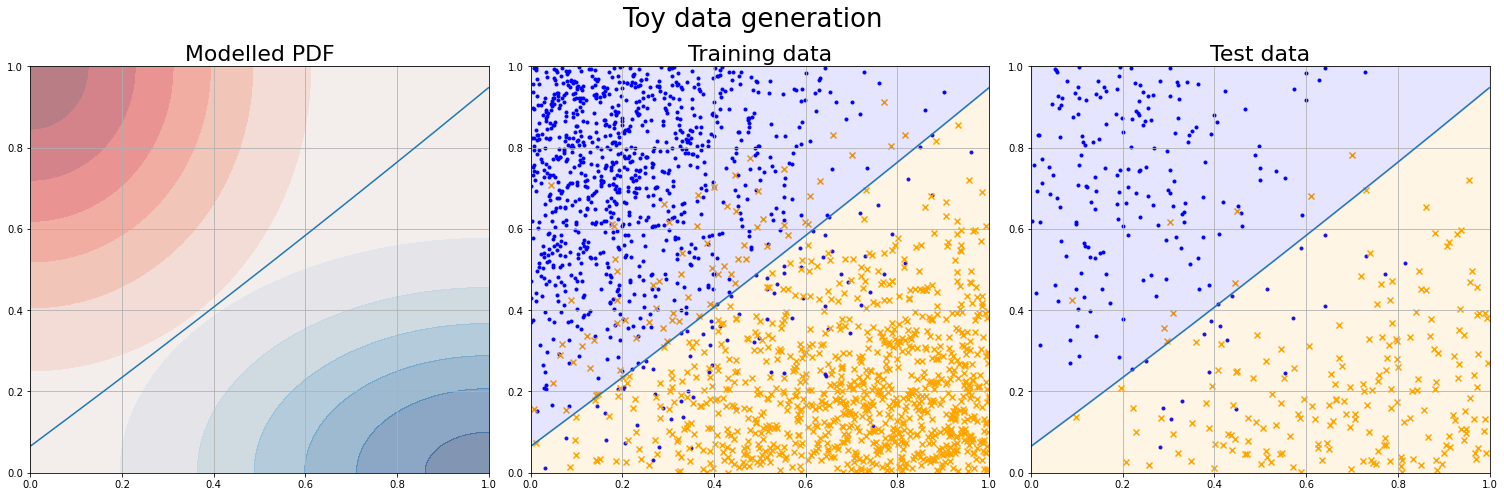

In [3]:
toy_plot = toy_model_plot(unit_sq, dist1, dist2, x_vals, y_est, x1, x2, x_test, labels_test)

#### Feature mapping

The matrix product state will have as many nodes as feature inputs. Having two dimensional data $(x_1, x_2)$, the feature map will have rank 2:

$$
\Phi(x_1, x_2) = \phi^{s_1}(x_1) \otimes \phi^{s_2}(x_2)
$$

Where $\phi(\cdot)$ is a feature map $\phi : \mathbb{R} \rightarrow \mathbb{R^d}$ where $d$ is the number of components of each index $s_{i}$ of the input $\Phi$. The impact of this value will be studied further.

The mapping is chosen as follows:
$$
\phi(x)_{s_i} = \sqrt{\binom{d - 1}{s_i - 1}} \cos^{d - s_i}\left(\frac{\pi}{2}x \right) \sin^{s_i - 1}\left(\frac{\pi}{2}x\right)
$$

It can be promptly shown that this mapping will be normalized to unity for any value of $d$.

In [4]:
d=3
#Feature mapping dataset
x_ftrain, y_htrain, x_ftest, y_htest = fmap(d, x_train, x_test, labels_train, labels_test)

2022-03-07 01:36:24.057253: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-07 01:36:24.078668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 01:36:24.078773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-03-07 01:36:24.078797: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-07 01:36:24.081512: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-07 01:36:24.081554: I tensorflow/stream_executor/pl

The tensor network is defined as a ```Keras``` model of a single layer. This allows for easy implementation of different algorithms of gradient descent and the respective back-propagation.

The layer is defined as a subclass of ```tensorflow.keras.layers.Layer```, inheriting its methods and attributes. The number of nodes in the matrix product state (MPS) equals the dimensionality of the input: an $N$-dimensional input will yield a tensor of rank $N$. With two-dimensional toy data, we use two MPS tensors. The bond dimension can be tuned as a hyper-parameter of the model. A larger bond dimension will, in principle, augment the classifier's predictive power.

2022-03-07 01:36:26.413701: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-07 01:36:26.430914: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


Total training time: 6.3824 seconds over 100 epochs.


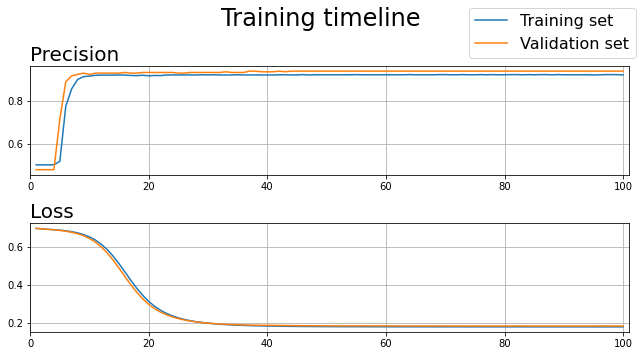

In [5]:
#model training

bond_dim = 5
tnetwork = build_model(d, bond_dim, 'SGD', batch_size=None)


t_i = time.time()
history = tnetwork.fit(x_ftrain, y_htrain, batch_size=16, validation_split=0.2, epochs=100, verbose=0, shuffle=True)
t_f = time.time()
delta_t = t_f - t_i
#plotting history
history_plot = plot_loss_acc(history.history, figsize = (9, 5), tight_layout='pad')
print(f'Total training time: {delta_t:.4f} seconds over {len(history.epoch)} epochs.')


Model achieved 93.000% precision on the test set.
Model achieved 92.750% precision on the test set.
Model achieved 92.750% precision on the test set.
Model achieved 88.000% precision on the test set.
Model achieved 90.250% precision on the test set.
Model achieved 92.250% precision on the test set.
Model achieved 92.000% precision on the test set.
Model achieved 91.500% precision on the test set.
Model achieved 91.250% precision on the test set.


/tmp/ipykernel_74339/1006743685.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_contours.show()


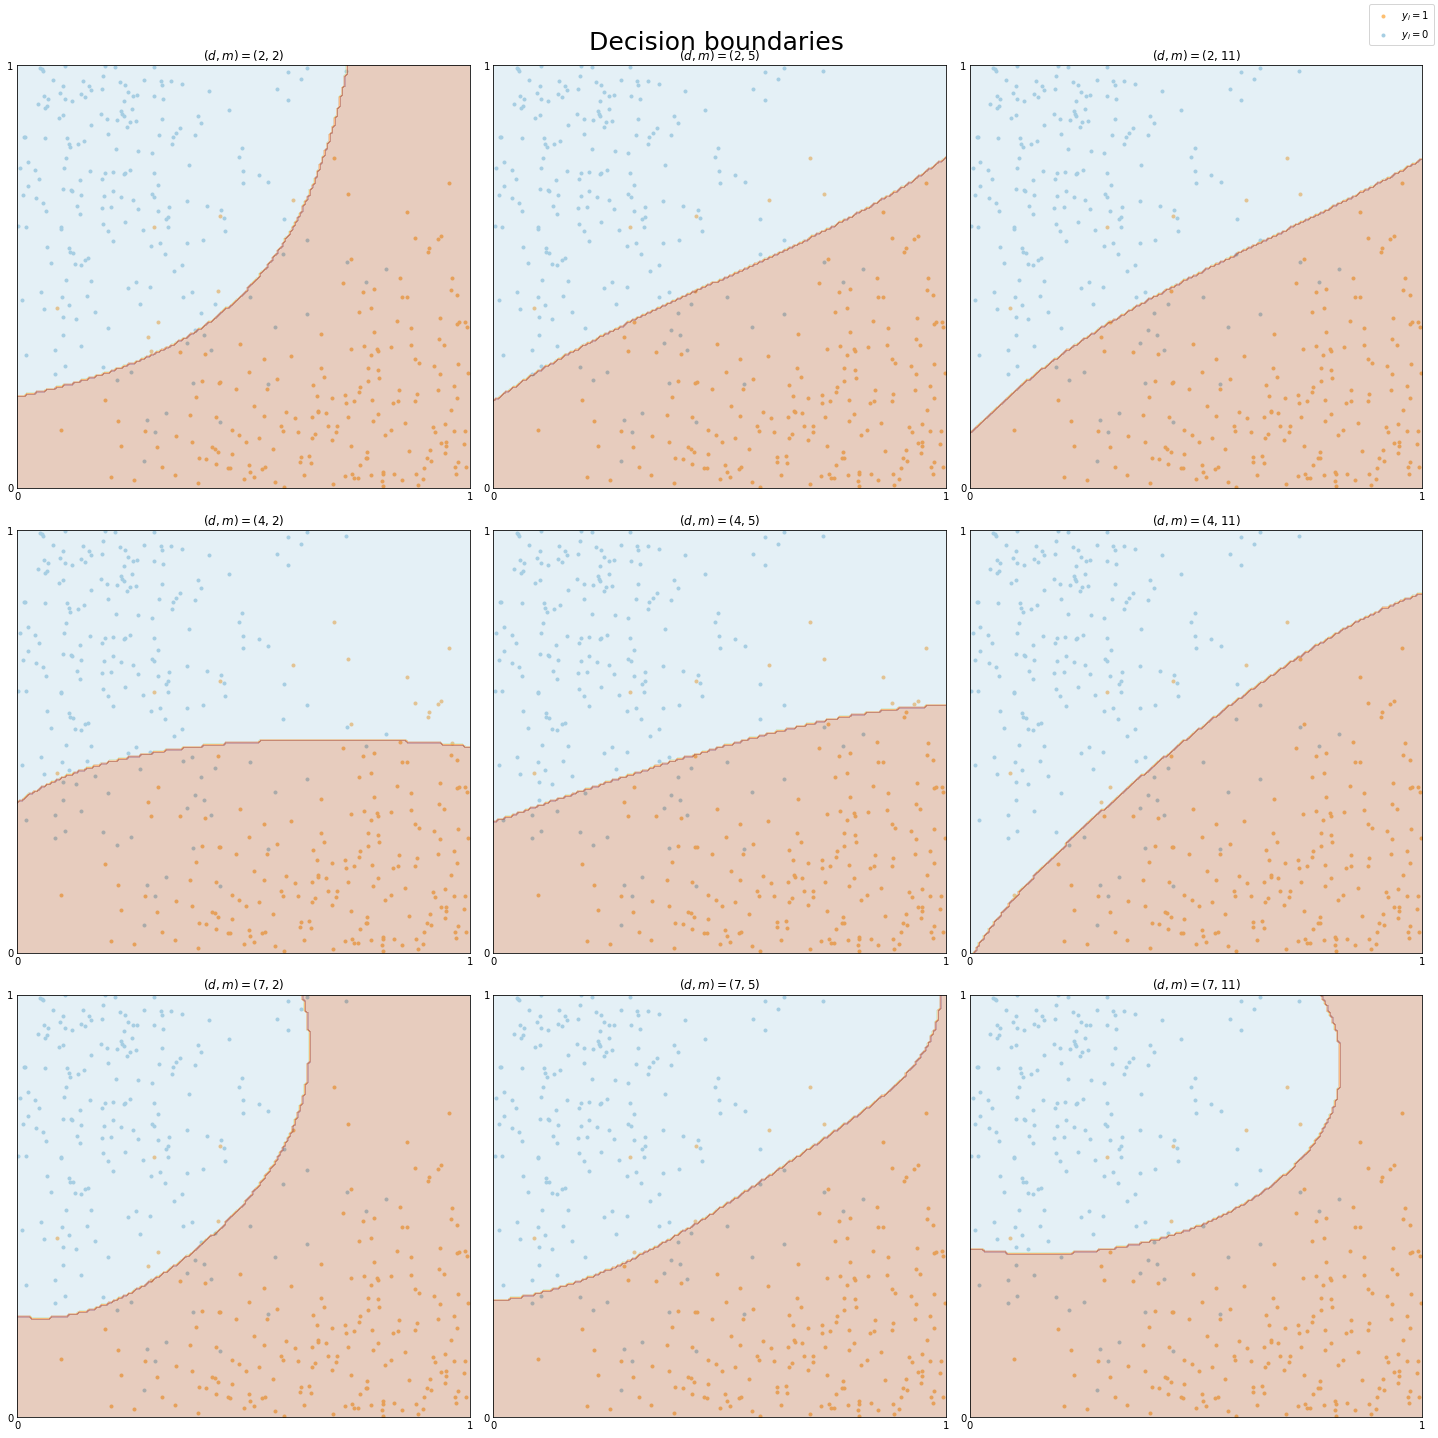

In [6]:
m_list = [2, 5, 11]
d_list = [2, 4, 7]

fig_contours, axs = decision_contours(d_list, m_list,
                            x_train, x_test, labels_train, labels_test,
                            tight_layout = 'pad', figsize=(20,20))

fig_contours.show()                            

### MNIST Handwritten digits

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data('mnist.npz')
x_train, x_test = x_train.reshape((60000, 28, 28, 1))/255, x_test.reshape((10000, 28, 28, 1))/255
avg_input = tf.keras.layers.AveragePooling2D((2,2))
x_train_red, x_test_red = avg_input(x_train), avg_input(x_test)
x_train, x_test = tf.convert_to_tensor(x_train_red), tf.convert_to_tensor(x_test_red)

y_train, y_test = tf.one_hot(y_train, 10), tf.one_hot(y_test, 10)
in_shape = x_train[0].shape

2022-03-07 01:37:07.643653: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 376320000 exceeds 10% of free system memory.


In [6]:
tn_MNIST = tf.keras.Sequential(
    [
     tf.keras.Input(shape=in_shape, batch_size=4096),
     Conv2D(28, (2,2), name='conv1', activity_regularizer=regularizers.l2(1e-4)),
     MaxPooling2D((2,2), name='maxpool1'),
     Flatten(),
     MNIST_TN(bond_dim = 11, activity_regularizer=regularizers.l2(1e-5)),
     Dense(10, activation='softmax', name='out_layer')])
tn_MNIST.summary()

tn_MNIST.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['Precision'])

ValueError: Exception encountered when calling layer "mnist_tn" (type MNIST_TN).

in user code:

    File "/home/jtfreitas/u_data/courses/Quantum_Info/QInfo_Final/final.py", line 87, in f  *
        input_vec = tf.reshape(input_vec, (16,63))

    ValueError: Cannot reshape a tensor with 67228 elements to shape [16,63] (1008 elements) for '{{node mnist_tn/loop_body/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](mnist_tn/loop_body/GatherV2, mnist_tn/loop_body/Reshape/shape)' with input shapes: [67228], [2] and with input tensors computed as partial shapes: input[1] = [16,63].


Call arguments received:
  • inputs=tf.Tensor(shape=(4096, 67228), dtype=float32)

In [17]:
check_point = ModelCheckpoint(filepath = os.getcwd()+'/tn_MNIST.h5', verbose = 0, save_best_only = True)
hist_dict = tn_MNIST.fit(x_train, y_train, batch_size = 16, epochs = 10, verbose = 1, validation_split = 0.2, shuffle=True, callbacks=[check_point])

Epoch 1/10
3000/3000 [==============================] - 9s 3ms/step - loss: 0.3350 - precision: 0.9435 - val_loss: 0.1486 - val_precision: 0.9675
Epoch 2/10
3000/3000 [==============================] - 8s 3ms/step - loss: 0.1323 - precision: 0.9709 - val_loss: 0.1153 - val_precision: 0.9743
Epoch 3/10
3000/3000 [==============================] - 8s 3ms/step - loss: 0.0988 - precision: 0.9783 - val_loss: 0.0973 - val_precision: 0.9774
Epoch 4/10
3000/3000 [==============================] - 8s 3ms/step - loss: 0.0800 - precision: 0.9817 - val_loss: 0.0881 - val_precision: 0.9810
Epoch 5/10
3000/3000 [==============================] - 8s 3ms/step - loss: 0.0688 - precision: 0.9841 - val_loss: 0.0846 - val_precision: 0.9804
Epoch 6/10
3000/3000 [==============================] - 8s 3ms/step - loss: 0.0602 - precision: 0.9860 - val_loss: 0.0795 - val_precision: 0.9815
Epoch 7/10
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0531 - precision: 0.9879 - val_loss: 0.0884 - 

In [18]:
loaded_MNIST = tf.keras.Sequential(
    [
     tf.keras.Input(shape=in_shape, batch_size=4096),
     Conv2D(28, (2,2), strides = (1,1), name='conv1'),
     MaxPooling2D((2,2), name='maxpool1'),
     Flatten(),
     MNIST_TN(bond_dim = 11, name='tn1'),
     Dense(10, activation='softmax', name='out_layer')])

loaded_MNIST.load_weights("tn_MNIST.h5")

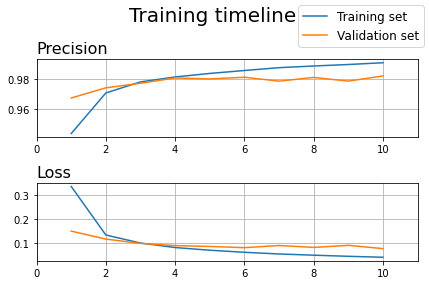

In [19]:
mnistc_fig = plot_loss_acc(hist_dict.history, starting_epoch=1, fontsize=16, tight_layout='pad')

In [20]:
predict_x = loaded_MNIST.predict(x_test, batch_size=x_test.shape[0]) 
classes_x = np.argmax(predict_x,axis=1)


# see which we predicted correctly and which not
correct_indices = np.nonzero(classes_x == np.argmax(y_test, axis=1))[0]
incorrect_indices = np.nonzero(classes_x != np.argmax(y_test, axis=1))[0]

2022-03-07 01:40:34.263270: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 443520000 exceeds 10% of free system memory.


(<Figure size 960x640 with 1 Axes>,
 <AxesSubplot:title={'center':'Test data'}, xlabel='Predicted labels', ylabel='True labels'>)

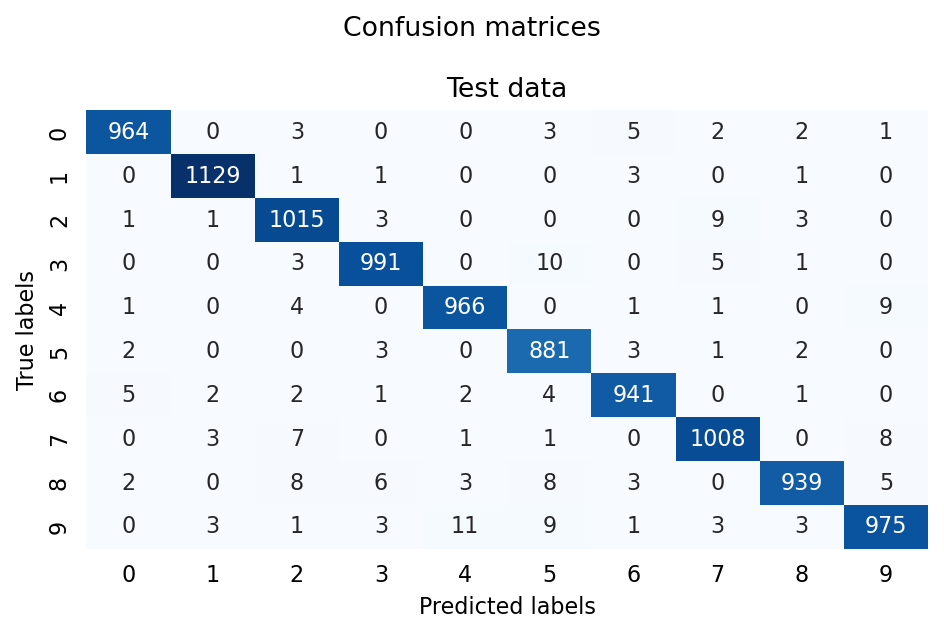

In [32]:
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), classes_x)
show_conf_matrix(conf_matrix, "Test data", dpi=160, tight_layout='pad')

### Fruit and vegetable recognition

In [20]:
train_dir = os.getcwd() + "/fruits360/Training"
test_dir  = os.getcwd() + "/fruits360/Test"
batch_size = 160
img_height = 100
img_width = 100

#Ideally, we want the batch to be large enough to contain at least one sample
#of each class
#Otherwise the model makes conclusions before seeing all types of data

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels = 'inferred',
  label_mode='categorical',
  color_mode = 'rgb',
  validation_split= 0.2,
  subset = 'training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels = 'inferred',
  label_mode='categorical',
  color_mode = 'rgb',
    validation_split= 0.2,
  subset = 'validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print('\nTest data:')
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels = 'inferred',
  label_mode='categorical',
  color_mode = 'rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.
Found 67692 files belonging to 131 classes.
Using 13538 files for validation.

Test data:
Found 22688 files belonging to 131 classes.


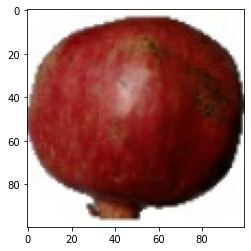

Label : 105


In [21]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds_train = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_train, labels_batch_train = next(iter(normalized_ds_train))

normalized_ds_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_val, labels_batch_val = next(iter(normalized_ds_val))

first_image = image_batch_train[0]
in_shape = first_image.shape

plt.imshow(first_image)
plt.show()
print(f"Label : {np.argmax(labels_batch_train[0])}")

In [22]:
#Building the tensor network

tn_reg_dense = regularizers.l2(1e-5)
tn_reg_conv  = regularizers.l2(1e-5)

tn_convolutional_model = tf.keras.Sequential([
  Input((in_shape)),
  Conv2D(4, kernel_size=4),
  Conv2DMPO(16, data_format = "channels_last", kernel_size=2, num_nodes=2, bond_dim=8, activation="relu", activity_regularizer = tn_reg_conv),
  MaxPooling2D(pool_size=(2,2)),
  Conv2DMPO(256, data_format = "channels_last", kernel_size=2, num_nodes=4, bond_dim=8, activation="relu", activity_regularizer = tn_reg_conv),
  MaxPooling2D(pool_size=(2,2)),
  # Conv2DMPO(256, data_format = "channels_last", kernel_size=2, num_nodes=4, bond_dim=8, activation="relu"),
  fruit_TN1(bond_dim = 5, activity_regularizer = tn_reg_dense),
  fruit_TN2(bond_dim = 1, activity_regularizer = tn_reg_dense),
  ])

tn_convolutional_model.summary()

lr_schedule = optimizers.schedules.ExponentialDecay(0.01, 800, 0.1)
#The loss was blowing up, meaning the training was reaching a point where
#the learning rate was too large, so I wrote it with a schedule which makes it
#decay to 10% every 500 training steps (batch runs)
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

opt = optimizers.Adam(learning_rate = lr_schedule, amsgrad=True)
tn_convolutional_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['Precision'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 97, 97, 4)         196       
                                                                 
 conv2dmpo_22 (Conv2DMPO)    (None, 97, 97, 16)        272       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2dmpo_23 (Conv2DMPO)    (None, 48, 48, 256)       1536      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 24, 24, 256)      0         
 g2D)                                                            
                                                                 
 fruit_tn1_5 (fruit_TN1)     (None, 64)               

In [24]:
check_point = ModelCheckpoint(filepath = os.getcwd()+'/tn_fruits.h5', verbose = 0, save_best_only = True)
with tf.device('GPU'):
    hist_dict_convolutional_tn = tn_convolutional_model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs = 5, verbose = 1, shuffle=True, callbacks=[check_point])

Epoch 1/10
339/339 [==============================] - 144s 426ms/step - loss: 2.6468 - accuracy: 0.2717 - val_loss: 2.1586 - val_accuracy: 0.3602
Epoch 2/10
254/339 [=====================>........] - ETA: 33s - loss: 1.7779 - accuracy: 0.4859

KeyboardInterrupt: 